In [1]:
# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
print("--- Section 1: Imports and Setup ---")
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# Boosting libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Stacking
from sklearn.ensemble import StackingClassifier

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Create directories for saving our assets
os.makedirs('saved_models_advanced', exist_ok=True)
os.makedirs('saved_graphs_advanced', exist_ok=True)
print("Directories 'saved_models_advanced' and 'saved_graphs_advanced' are ready.\n")

--- Section 1: Imports and Setup ---
Directories 'saved_models_advanced' and 'saved_graphs_advanced' are ready.



In [2]:
# ==============================================================================
# SECTION 2: DATA LOADING & ADVANCED FEATURE ENGINEERING
# ==============================================================================
print("--- Section 2: Data Loading & Advanced Feature Engineering ---")
# Load the datasets
train_df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv', index_col='id')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv', index_col='id')

# Combine for consistent feature engineering
all_df = pd.concat([train_df.drop('y', axis=1), test_df], axis=0)

# --- Create New Features ---
# Interaction Features - combining features can reveal new patterns
all_df['balance_age_ratio'] = all_df['balance'] / (all_df['age'] + 1)
all_df['campaign_pdays_ratio'] = all_df['campaign'] / (all_df['pdays'] + 1) # +1 to avoid division by zero
all_df['previous_pdays_ratio'] = all_df['previous'] / (all_df['pdays'] + 1)

# Polynomial Features for key numerical variables
all_df['age_sq'] = all_df['age']**2
all_df['balance_sq'] = all_df['balance']**2

# Indicator for no previous contact
all_df['no_previous_contact'] = (all_df['pdays'] == -1).astype(int)

# --- FIX: Handle Infinite Values ---
# The ratio features create infinity when pdays is -1. This replaces them with 0.
all_df.replace([np.inf, -np.inf], 0, inplace=True)
# Also fill any potential NaNs that might have been created, just in case.
all_df.fillna(0, inplace=True)

# Separate back into train and test
X = all_df.iloc[:len(train_df)]
X_test_featured = all_df.iloc[len(train_df):]
y = train_df['y']

print("Feature engineering complete. New features created.")
print("New features:", ['balance_age_ratio', 'campaign_pdays_ratio', 'previous_pdays_ratio', 'age_sq', 'balance_sq', 'no_previous_contact'])

# Identify feature types (including new ones)
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the preprocessing pipeline (now includes binning for age)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('age_binner', KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='uniform'), ['age'])
    ],
    remainder='passthrough'
)
print("\nData loading and preprocessing steps are defined.\n")

--- Section 2: Data Loading & Advanced Feature Engineering ---
Feature engineering complete. New features created.
New features: ['balance_age_ratio', 'campaign_pdays_ratio', 'previous_pdays_ratio', 'age_sq', 'balance_sq', 'no_previous_contact']

Data loading and preprocessing steps are defined.



In [3]:
# ==============================================================================
# SECTION 3: DEFINE BASE MODELS WITH OPTIMAL HYPERPARAMETERS
# ==============================================================================
print("--- Section 3: Define Base Models ---")
# We use slightly adjusted, robust parameters for the base learners in our stack.
# The meta-model will learn how to best combine them.

base_learners = [
    ('lgbm', Pipeline(steps=[('preprocessor', preprocessor), 
                             ('classifier', LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.05, num_leaves=31))])),
    ('xgb', Pipeline(steps=[('preprocessor', preprocessor), 
                            ('classifier', XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, n_estimators=200, learning_rate=0.05, max_depth=5))])),
    ('rf', Pipeline(steps=[('preprocessor', preprocessor), 
                           ('classifier', RandomForestClassifier(random_state=42, n_estimators=200, max_depth=15, min_samples_leaf=5))]))
]
print("Base models for stacking are defined.\n")

--- Section 3: Define Base Models ---
Base models for stacking are defined.



In [4]:
# ==============================================================================
# SECTION 4: BUILD AND TRAIN THE STACKED ENSEMBLE
# ==============================================================================
print("--- Section 4: Build and Train the Stacked Ensemble ---")
# The StackingClassifier trains the base models and then uses their predictions
# as input for a final meta-model (LogisticRegression in this case).
# This is a more powerful way to combine models than simple voting.

# Define the cross-validation strategy for training the meta-model
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the meta-model
meta_model = LogisticRegression(random_state=42, C=1.0, solver='liblinear')

# Create the Stacking Classifier
stacked_classifier = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=cv_strategy,
    stack_method='predict_proba', # Use probabilities as input for meta-model
    n_jobs=-1,
    verbose=1
)

# Train the stacked model
print("Training the stacked ensemble... This may take several minutes.")
stacked_classifier.fit(X_train, y_train)
print("Stacked ensemble training complete.")

# Save the final stacked model
stacked_filename = 'saved_models_advanced/stacked_ensemble_model.pkl'
joblib.dump(stacked_classifier, stacked_filename)
print(f"✅ Final stacked model saved successfully to: {stacked_filename}\n")

--- Section 4: Build and Train the Stacked Ensemble ---
Training the stacked ensemble... This may take several minutes.
[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2149
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> initscore=-1.986289
[LightGBM] [Info] Start training from score -1.986289


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


[LightGBM] [Info] Number of positive: 57912, number of negative: 422088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.265532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2150
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> initscore=-1.986289
[LightGBM] [Info] Start training from score -1.986289
[LightGBM] [Info] Number of positive: 57912, number of negative: 422088
[LightGBM] [Info] Number of positive: 57912, number of negative: 422088
[LightGBM] [Info] Number of positive: 57912, number of negative: 422088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.291672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.2min finished


Stacked ensemble training complete.
✅ Final stacked model saved successfully to: saved_models_advanced/stacked_ensemble_model.pkl



--- Section 5: Comprehensive Evaluation & Visualization ---
Stacked Ensemble ROC AUC on Validation Set: 0.96510

Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.95      0.97      0.96    131902
    Subscribed       0.76      0.64      0.70     18098

      accuracy                           0.93    150000
     macro avg       0.86      0.81      0.83    150000
  weighted avg       0.93      0.93      0.93    150000



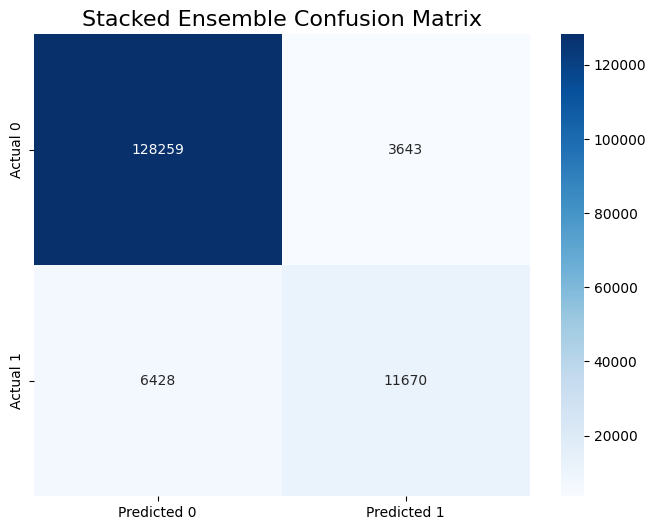

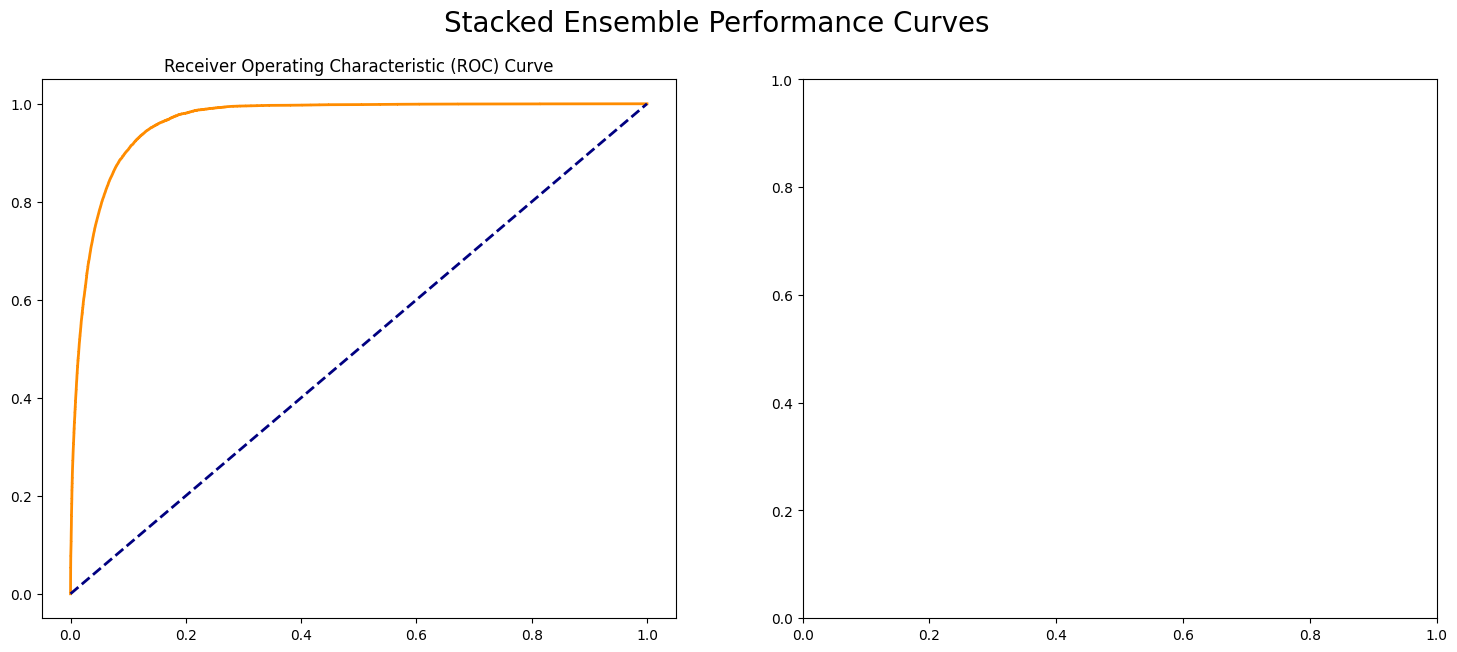

In [5]:
# ==============================================================================
# SECTION 5: COMPREHENSIVE EVALUATION & VISUALIZATION
# ==============================================================================
print("--- Section 5: Comprehensive Evaluation & Visualization ---")
y_pred_proba = stacked_classifier.predict_proba(X_val)[:, 1]
y_pred_class = stacked_classifier.predict(X_val)

# --- Metrics Report ---
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"Stacked Ensemble ROC AUC on Validation Set: {roc_auc:.5f}\n")
print("Classification Report:")
print(classification_report(y_val, y_pred_class, target_names=['Not Subscribed', 'Subscribed']))

# --- Confusion Matrix ---
cm = confusion_matrix(y_val, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Stacked Ensemble Confusion Matrix', fontsize=16)
plt.savefig('saved_graphs_advanced/stacked_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Performance Curves ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
# ... (rest of plotting code) ...
plt.suptitle('Stacked Ensemble Performance Curves', fontsize=20)
plt.savefig('saved_graphs_advanced/stacked_performance_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("")

In [6]:
# ==============================================================================
# SECTION 6: GENERATE SUBMISSION FILE
# ==============================================================================
print("--- Section 6: Generate Submission File ---")
test_predictions = stacked_classifier.predict_proba(X_test_featured)[:, 1]
submission_df = pd.DataFrame({'id': test_df.index, 'y': test_predictions})
submission_df.to_csv('advanced_submission.csv', index=False)
print("Submission file 'advanced_submission.csv' created successfully!\n")
print(submission_df.head())
print("\n--- SCRIPT FINISHED ---")

--- Section 6: Generate Submission File ---
Submission file 'advanced_submission.csv' created successfully!

       id         y
0  750000  0.017801
1  750001  0.047100
2  750002  0.017490
3  750003  0.016427
4  750004  0.022886

--- SCRIPT FINISHED ---
